<a href="https://colab.research.google.com/github/Anku5hk/The_ML_Workflow/blob/master/Fast_ai_assignments/emotion_classifier_fastai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Emotion Classifier Notebook**

This uses KDEF dataset found <a href='http://www.emotionlab.se/kdef/'>here</a>. We'll use fast.ai lib to generate a model that'll simply classify emotions from given input face image. <br>



In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *
from pathlib import Path
import os

In [0]:
# download the data and unzip
data_dir = Path.home()/".fastai/data/KDEF/"
src_data_dir = data_dir/"KDEF_and_AKDEF"
flat_dir = data_dir/"flat"
!mkdir -p {flat_dir}
zip_url = 'http://kdef.se/download/KDEF_and_AKDEF.zip'
zip_file = data_dir/"kdef.zip"
if not src_data_dir.exists():
    !wget -O {zip_file} {zip_url}
    !unzip {zip_file} -d {data_dir}

In [0]:
# create a dataset folder to copy all imgs into a single folder
dataset = data_dir/".dataset/"
!mkdir -p {dataset}

In [0]:
# create dict for better understanding
classes_dict = { 'AF' : 'Afraid',
                    'AN' : 'Angry',
                    'DI' : 'Disgusted',
                    'HA' : 'Happy',
                    'NE' : 'Neutral',
                    'SA' : 'Sad',
                    'SU' : 'Surprised'}
classes = classes_dict.values()

In [0]:
# make dataset folders
# data/train/class1  data/train/class2
train_path = Path('/content/data/train/')
!mkdir -p {train_path}
for cls in classes:
  class_fld = Path('/content/data/train/'+cls+'/')
  !mkdir -p {class_fld}
!ls {train_path}

Afraid	Angry  Disgusted  Happy  Neutral  Sad  Surprised


In [0]:
# copy all imgs to 1 folder and fix some data mislabeling
if not os.listdir(dataset):
    src_dir = src_data_dir/"KDEF"
    for fld in src_dir.iterdir():
        for img_file in fld.iterdir():
            imgs_dst = dataset.joinpath(img_file.name)
            os.link(img_file, imgs_dst)
    # Some files are misnamed, so fix them manually here
    rename_dict = {
        'AF31V': 'AF31SAHL',
        'AM31H': 'AM31SUHR',
    }
    for frm in rename_dict:
        to = rename_dict[frm]
        os.rename(dataset/(frm + ".JPG"), dataset/(to + ".JPG"))

In [0]:
# get imgs
fnames = get_image_files(dataset, check_ext=False)
pat = r'\w{4}(\w{2})\w{1,2}\.JPG'

In [0]:
# copy the images to respective class folder 
import shutil
from os import path
data_path = '/content/data/train/'
# to train/class*
for fn in fnames:
    res = re.search(pat, fn.as_posix())
    class_id = res.group(1)
    img_name = res.group(0)
    new_img_path = data_path + classes_dict[class_id] +'/'+ img_name
    to = path.realpath(new_img_path) # to real path
    shutil.copyfile(fn,to)

In [0]:
# remove unecessary folders
import shutil
shutil.rmtree(data_dir)

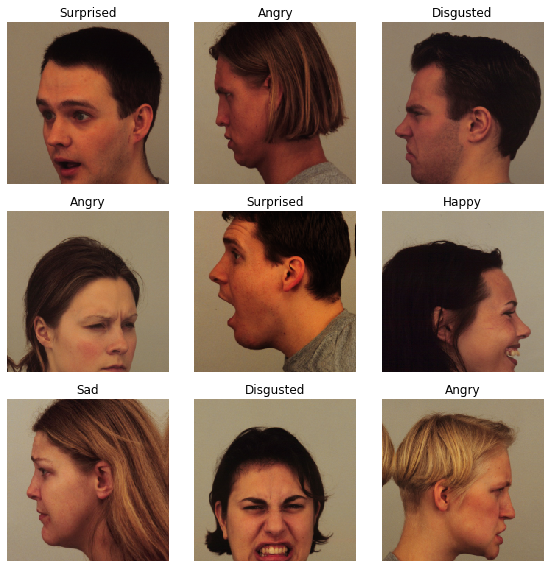

In [0]:
# create a dataset
tfms = get_transforms(max_zoom=1, max_rotate=10)
data_path = '/content/data/'
data = ImageDataBunch.from_folder(data_path, ds_tfms=tfms, seed=42, valid_pct=0.1,size=220, bs=12)
data.normalize(imagenet_stats)
data.show_batch(rows=3, figsize=(8,8))

In [0]:
# using resnet-50
learn = cnn_learner(data, models.resnet50, metrics=error_rate)
learn.fit_one_cycle(8, max_lr=slice(1e-3))
learn.save("res-50-1")

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.470537,1.845268,0.606122,02:05
1,2.036695,1.508595,0.555102,02:05
2,1.613193,1.261119,0.471429,02:08
3,1.320420,1.022733,0.379592,02:14
4,1.124535,0.941092,0.342857,02:08
5,1.100889,0.818333,0.304082,02:07
6,0.968576,0.763362,0.289796,02:12
7,0.921504,0.802355,0.302041,02:08


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


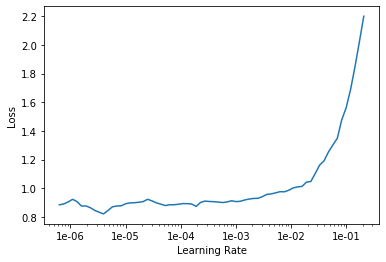

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(6,max_lr=slice(1e-4,1e-2))

epoch,train_loss,valid_loss,error_rate,time
0,1.357537,1.210625,0.363265,02:09
1,1.306529,1.317364,0.416327,02:11
2,0.890214,0.831188,0.291837,02:10
3,0.639503,0.482994,0.179592,02:10
4,0.472827,0.332774,0.106122,02:09
5,0.362186,0.312256,0.112245,02:10


In [0]:
learn.save("res-50-2")

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


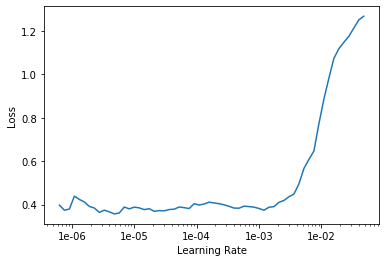

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(4,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.335599,0.306024,0.114286,02:08
1,0.406778,0.306006,0.112245,02:09
2,0.344079,0.307256,0.118367,02:09
3,0.317933,0.299358,0.114286,02:09


In [0]:
learn.save('res-50-3')

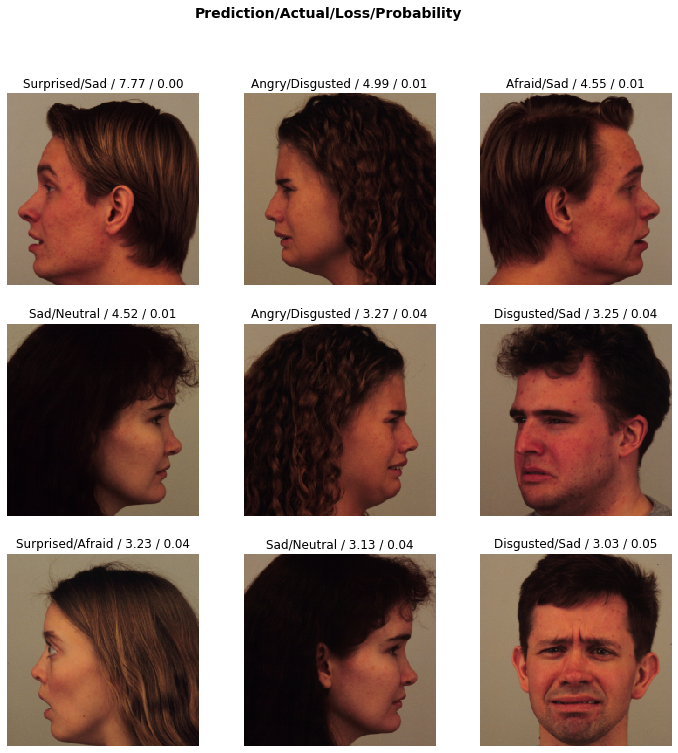

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(12,12))

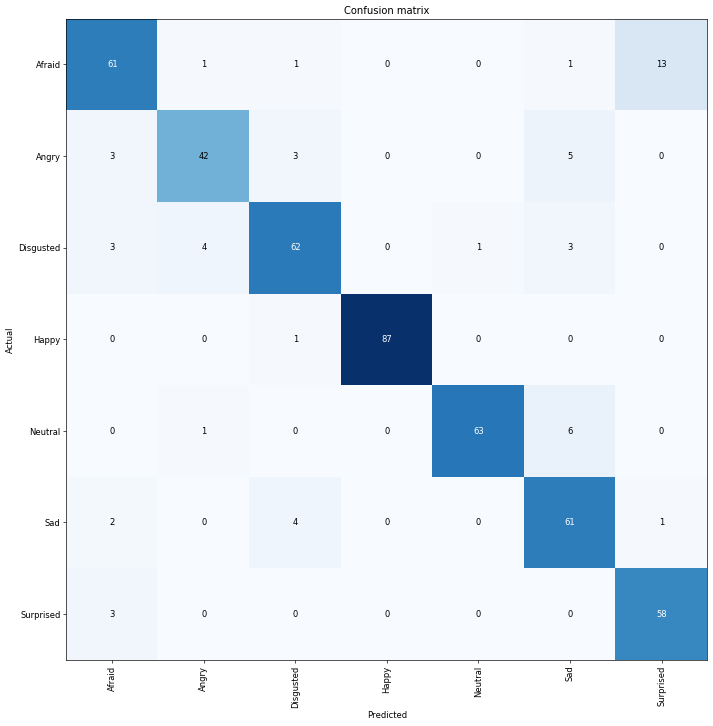

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)